In [4]:
from pathlib import Path
src_root = Path().resolve()
list(src_root.iterdir())

[PosixPath('/home/hangsi/projects/university/marble_maze/marble_maze/image_preprocessing.py'),
 PosixPath('/home/hangsi/projects/university/marble_maze/marble_maze/preprocessing.ipynb'),
 PosixPath('/home/hangsi/projects/university/marble_maze/marble_maze/.ipynb_checkpoints'),
 PosixPath('/home/hangsi/projects/university/marble_maze/marble_maze/data'),
 PosixPath('/home/hangsi/projects/university/marble_maze/marble_maze/main.py'),
 PosixPath('/home/hangsi/projects/university/marble_maze/marble_maze/build_graph.py')]

In [5]:
import matplotlib.pyplot as plt

In [32]:
import cv2
import numpy as np


def binary_image_to_grid(binary_image, block_size=10):
    """
    Convert a binary image to a grid where each cell represents a block of pixels.
    Walls are 0, paths are 1.

    Parameters:
    - binary_image: The binary image of the maze (numpy array).
    - block_size: The size of the block to consider for each grid cell. This helps reduce the maze's resolution for easier processing.

    Returns:
    - A 2D list representing the maze grid.
    """
    # Initialize the grid
    height, width = binary_image.shape
    grid_height, grid_width = height // block_size, width // block_size
    grid = np.zeros((grid_height, grid_width), dtype=int)

    # Populate the grid
    for i in range(grid_height):
        for j in range(grid_width):
            block = binary_image[i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size]
            # Consider it a path if more than half of the block is white
            if np.sum(block) > (block_size ** 2 * 255 / 2):
                grid[i, j] = 1

    return grid


# Example of converting a binary image to a grid
# binary_image = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY)[1]
# maze_grid = binary_image_to_grid(binary_image, block_size=10)

def load_photo():
    img_path = src_root / "data" / "maze.png"
    image = cv2.imread(str(img_path))
    return image

# def maze_photo_to_graph():
def photo_to_thresholded_matrix(photo):
    # Load image and convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply thresholding
    _, binary_image = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY)
    
    # Assume we have a function to convert binary_image to a maze grid
    maze_grid = binary_image_to_grid(binary_image)
    return maze_grid

# Solve the maze - assuming we have start and end points, and a solving function
# path = solve_maze(maze_grid, start_point, end_point)

# Function to draw the path on the original image
def draw_path(image, path):
    # Implementation depends on how the path is represented
    pass

# Visualize the solution
# solution_image = draw_path(image, path)
# cv2.imshow('Solution', maze_grid)  # solution_image
# cv2.waitKey(0)
# cv2.destroyAllWindows()


image = load_photo()
maze_grid = photo_to_thresholded_matrix(image)

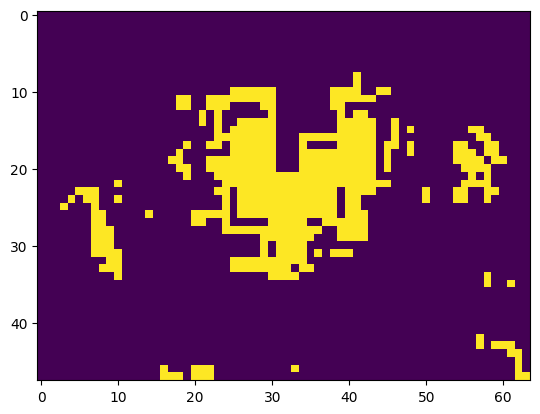

In [33]:
plt.imshow(maze_grid)
plt.show()

In [34]:
def smrt_edge_filtering(image):
    # Convert to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Work with the Value channel or experiment with other channels
    value_channel = hsv_image[:, :, 2]
    
    # Apply adaptive thresholding
    thresholded = cv2.adaptiveThreshold(value_channel, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY_INV, 11, 2)
    
    # Morphological operations for refinement
    kernel = np.ones((3,3), np.uint8)
    opened = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, kernel)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
    
    return closed
    
    # Contour detection and filtering seems a bit sus - may not be doing anything useful!
    
    # Detect and filter contours
    contours, _ = cv2.findContours(closed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # TODO Filtering logic goes here
    
    # contours could be used directly, but I don't know what we have got so need to visualise.
    # Step 1: Prepare a blank image
    blank_image = np.zeros(image.shape[:2], dtype="uint8")  # Creating a black canvas
    
    # Step 2: Draw the contours
    # We draw the contours in white on the black canvas. The '-1' indicates all contours.
    cv2.drawContours(blank_image, contours, -1, (255), thickness=cv2.FILLED)
    
    # Optional Step 3: Further refine the binary maze image
    kernel = np.ones((5,5), np.uint8)
    cleaned_image = cv2.morphologyEx(blank_image, cv2.MORPH_CLOSE, kernel)
    
    return cleaned_image


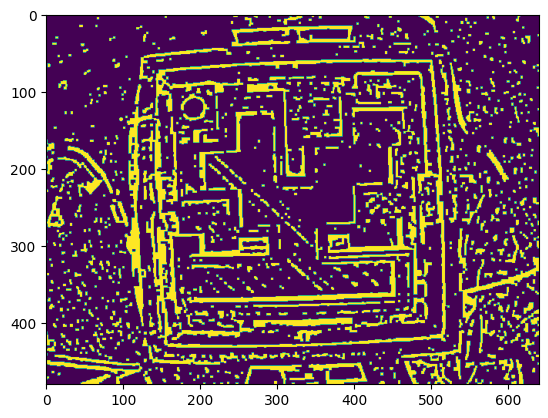

In [35]:
contours = smrt_edge_filtering(image)

plt.imshow(contours)
plt.show()

In [36]:
# Hough transform for shape detection?
import cv2
print(cv2.__version__)
print([x for x in dir(cv2) if 'Hough' in x])

4.9.0
['GeneralizedHough', 'GeneralizedHoughBallard', 'GeneralizedHoughGuil', 'HoughCircles', 'HoughLines', 'HoughLinesP', 'HoughLinesPointSet', 'HoughLinesWithAccumulator', 'createGeneralizedHoughBallard', 'createGeneralizedHoughGuil']


In [37]:
def hough_n_friends(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Edge detection
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    
    # Hough Line Transform
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    
    # Assuming we have a function to filter lines and find the frame corners
    frame_corners = find_frame_corners(lines)
    
    # Create a mask based on the frame corners
    mask = np.zeros_like(gray)
    cv2.fillPoly(mask, [np.array(frame_corners)], 255)
    
    # Apply the mask to isolate the maze
    masked_image = cv2.bitwise_and(gray, mask)
    
    # Display or further process `masked_image`
    return masked_image

In [38]:
def hough_line_candidates(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Edge detection
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    
    # Assuming 'image' is your original image and 'edges' is the edge-detected image
    # Apply Hough Line Transform
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    
    
    # Create a copy of the original image to draw lines on
    image_with_lines = image.copy()
    
    # Iterate through the list of lines
    for line in lines:
        rho, theta = line[0]  # Extract rho and theta
        a = np.cos(theta)  # Calculate the cosine of theta
        b = np.sin(theta)  # Calculate the sine of theta
        x0 = a * rho  # x-coordinate of the line's origin
        y0 = b * rho  # y-coordinate of the line's origin
    
        # Calculate the coordinates of the two points that define the line
        x1 = int(x0 + 1000 * (-b))  # Point extending to the right
        y1 = int(y0 + 1000 * (a))   # Point extending to the right
        x2 = int(x0 - 1000 * (-b))  # Point extending to the left
        y2 = int(y0 - 1000 * (a))   # Point extending to the left
    
        # Draw the line on the image
        cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 0, 255), 2)
    return image_with_lines

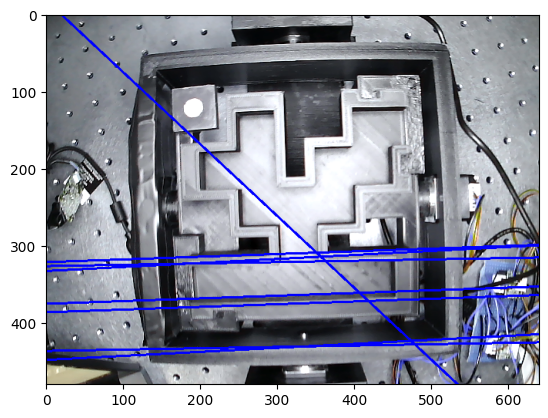

In [39]:
image_with_lines = hough_line_candidates(load_photo())

plt.imshow(image_with_lines)
plt.show()

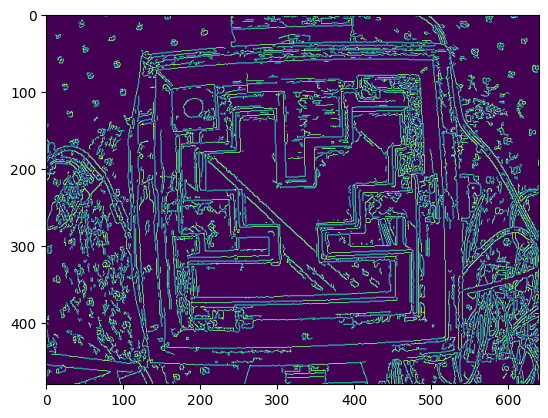

In [14]:
def canny_edges(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Edge detection
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    return edges

plt.imshow(canny_edges(image))
plt.show()